(figure-detection)=
# 図形の検出

OpenCVを用いて画像中から図形を検出してみよう。図形の検出は、画像からのエッジの情報を取り出す処理と、エッジ情報を元に境界線を認識する処理、境界線から図形の形状を分類する処理の三つに分けられる。

さらに、実写真から図形を取り出す場合には、いわゆるパースを考慮した図形の検出が必要になる。

## 単純図形の検出

まず手始めに、以下の単純な図形が描かれた画像を題材として、図形の検出方法を見てみる。

```{image} ../../data/figures.png
:align: center
:width: 80%
```

### エッジの検出

[「OpenCVの基本」](edge-detection)で、紹介したように、画像からエッジの情報を得るアルゴリズムには**Sobelフィルタ**や**Cannyフィルタ**がある。

これらのフィルタを画像に適用した後、候補となる画素の中で勾配が一定以上となる場所を閾値処理により取り出す二値化処理を施すことで、最終的なエッジが得られる。

以下がOpenCVでSobelフィルタとCanny法によりエッジ画像を得るプログラムと、その結果である。なお、Cannyフィルタは直接、二値画像を出力するため、二値化の処理はSobelフィルタの結果だけに適用している。

In [1]:
import cv2
import numpy as np

# 画像の読み込み
image = cv2.imread("../../data/figures.png", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 画像をグレースケールにする
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sobelフィルタ
dx = cv2.Sobel(gray, cv2.CV_8U, 1, 0)
dy = cv2.Sobel(gray, cv2.CV_8U, 0, 1)
sobel = np.sqrt(dx * dx + dy * dy)
sobel = (sobel - sobel.min()) / (sobel.max() - sobel.min())
sobel = (sobel * 255.0).astype("uint8")
_, sobel = cv2.threshold(sobel, 10, 255, cv2.THRESH_BINARY)

# Canny法
canny = cv2.Canny(gray, 100, 200)

なお、上記のプログラム中の `cv2.threshold`は8ビット符号なし整数(0から255の値)で画素が表わされているグレースケール画像に対して、閾値による二値化処理を行う関数である。上記の例では、グレースケール画像 `sobel`に対して、画素値が10以上であれば白とみなす、という処理を行っている。

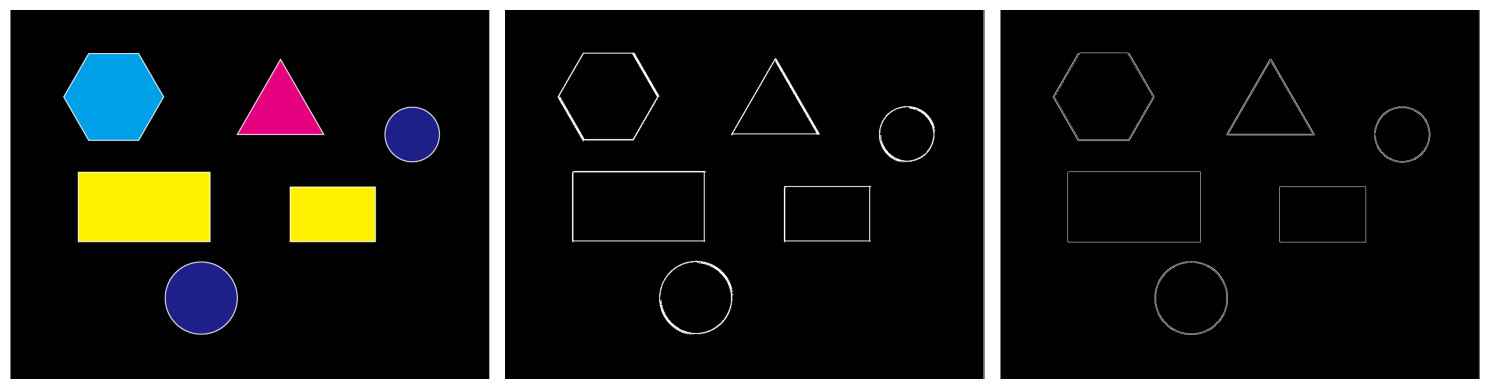

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.imshow(image)
ax.axis("off")

ax = fig.add_subplot(132)
ax.imshow(sobel, cmap="gray")
ax.axis("off")

ax = fig.add_subplot(133)
ax.imshow(canny, cmap="gray")
ax.axis("off")

plt.tight_layout()
plt.show()

### エッジの統合

結果を見てみると、上記の入力画像は**図形の輪郭線が幅を持つため、エッジが二重線で検出されている**ことが分かる。もちろん、これで間違いとは言えないが、エッジが内側の線と外側の線の間で曖昧に検出されており、この後の輪郭線検出に影響を及ぼす可能性がある。この問題は自然画像を入力とする場合には、より顕著となる。

そこで、輪郭線を抽出する前に、モルフォロジー演算によりエッジの統合を行っておく。モルフォロジー演算は一般的には二値画像を入力として、白色の領域を広げたり狭めたりする操作である(モルフォロジー演算の数学的な意味とは解釈が異なるので注意)。今回は白色領域を広げる処理であるdilationと白色領域を狭める処理であるerosionを連続して施すことでエッジの統合を行う。

モルフォロジー演算は構造要素と呼ばれる小さな画像のようなものを入力の二値画像にしたがって繰り返す操作に対応する。したがって、OpenCV(やMATLABなどの他のライブラリ)では、モルフォロジー演算の関数は二値画像と構造要素を引数にとる。OpenCVを用いる場合には、dilationとerosionはそれぞれ以下のようなコードで実現される。

In [3]:
binary = sobel.copy()
res_dilate = cv2.dilate(binary, np.ones((5, 5), dtype=binary.dtype))
res_erode = cv2.erode(binary, np.ones((5, 5), dtype=binary.dtype))

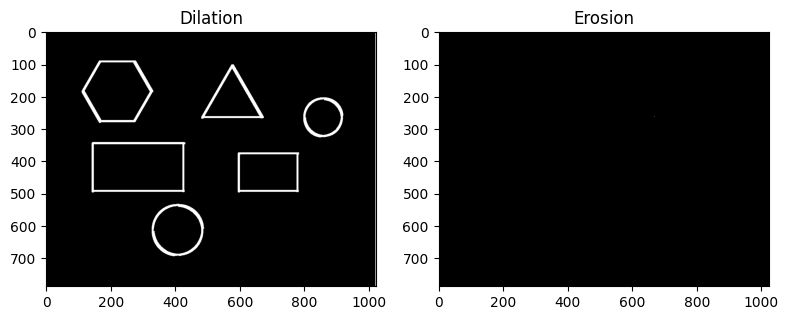

In [4]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(res_dilate, cmap="gray")
ax.set_title("Dilation")
ax = fig.add_subplot(122)
ax.imshow(res_erode, cmap="gray")
ax.set_title("Erosion")
plt.tight_layout()
plt.show()

エッジを統合する場合、エッジが白色の領域に検出されているとすると、**先にdilation、次にerosionの順序で処理を施す**。dilationにより二重のエッジのそれぞれが太くなり、重なることで、太い1本のエッジとなる。その後、erosionをかけることで、そのエッジが細くなり、1本の細いエッジとなる。

In [5]:
res = sobel.copy()
res = cv2.dilate(res, np.ones((5, 5), dtype=binary.dtype))
res = cv2.erode(res, np.ones((5, 5), dtype=binary.dtype))

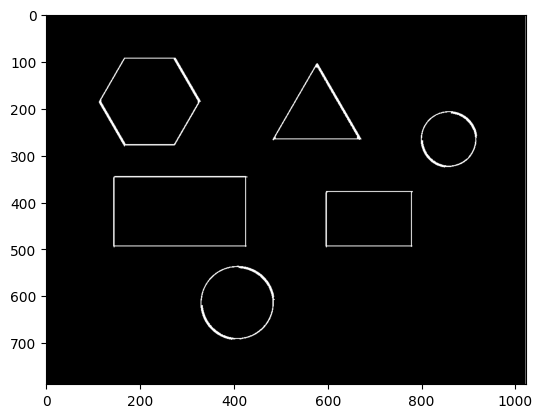

In [6]:
plt.imshow(res, cmap="gray")
plt.show()

上記の結果の通り、dilationとerosionを組み合わせることで二本の細いエッジが一本のエッジに統合されていることが分かる。

なおdilationの後にerosionをする操作を特に**closing**と呼び、反対にerosionの後にdilationをする操作を**opening**と呼ぶ。白色の輪郭線を統合する処理は**closing**に対応しており、以下のコードでも同じことができる。

In [7]:
binary = sobel.copy()
res_close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), dtype=binary.dtype))

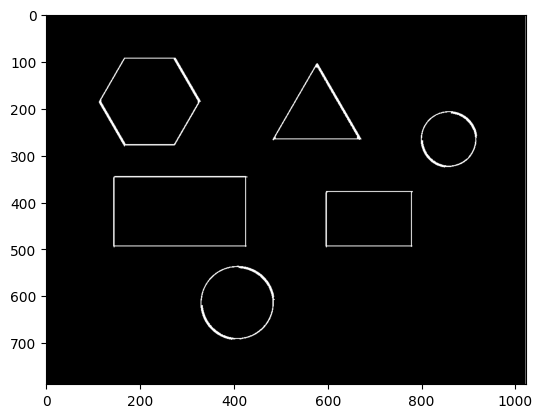

In [8]:
plt.imshow(res_close, cmap="gray")
plt.show()

### 輪郭線の検出

ここまでに検出したエッジの情報を使って輪郭線を抽出する。輪郭線の抽出にはOpenCVの `findContours`という関数を用いる。この関数には1985年にSuzukiさんとAbeさんという日本人が提案したアルゴリズムが実装されている(以下の論文)。

> (*1) S. Suzuki and K. Abe, “Topological structural analysis of digitized binary images by border following”, Computer Vision, Graphics and Image Processing”, 1985.

このアルゴリズムは二値画像(1がエッジで0が背景の色とする)を**ラスタスキャン** (最初の列を左から右に見ていき、右端に到達したら、左から右に見ていく、以後繰り返し) していき、**1が見つかったら、その画素から始まる輪郭線を追跡する**。

輪郭線の追跡は、**今見ている画素の周りを時計回りに見ていき、初めて1となる画素にスキャン位置を移動する、という操作を繰り返す**ことで行われる。端点に到達するか、元の位置の画素に戻ってきたら、再びラスタスキャン順に値が1の画素で、まだどの輪郭にも含まれていない画素を探し、以後、同様の処理を繰り返していく。

OpenCVの `findContours`は3つの引数を取り、第1引数が入力の二値画像、第2引数が検出される輪郭線の階層関係、第3引数が抽出する輪郭線をどのように近似表現するかを表す。代表的な使い方は以下の通り。

In [9]:
contours, _ = cv2.findContours(res_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

第2引数の`cv2.RETR_EXTERNAL`は二重丸のような階層的な輪郭線が現れたときに最も外側の閉曲線のみを抽出する。また第3引数の`cv2.CHAIN_APPROX_SIMPLE`は抽出される輪郭線が0度(=水平)、90度(=垂直)、45度, 135度の向きに直線的につながるときに、それらを端点だけで近似することを表わす。

この他の使い方については公式のドキュメントを参考にしてほしい。

### 輪郭線の描画

上記の方法で検出された輪郭線は`findContours`と対になる`drawContours`で描画できる。この関数は以下の引数を取る。

- 第1引数: 描画先の画像
- 第2引数: `findContours`で検出された輪郭線
- 第3引数: 配列中の何番目の輪郭線を描画するか (-1は全て描画する)
- 第4引数: 輪郭線を描画する色
- 第5引数: 輪郭線を描画する太さ
- 第6引数: 輪郭線の描画スタイル (`cv2.LINE_AA`はアンチエイリアシングを行う)

こちらも詳しい使い方は公式のドキュメントを参考にしてほしい。

実際に上記の方法で検出した輪郭線を描画してみたものが以下である。見ての通り、各図形の外側と画像自体の輪郭に輪郭線が検出されていることがわかる。

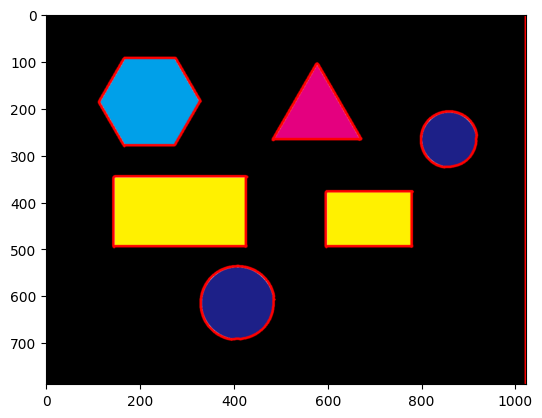

In [10]:
cv2.drawContours(image, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(image)
plt.show()

### 輪郭線の分類

各輪郭線がどのような図形か(円か？多角形か？そうなら何角形か？)を判別するには、**輪郭線を多角形として近似して、その頂点の数を調べれば良い**。

`findContours` で検出された輪郭線 (`cv2.CHAIN_APPROX_SIMPLE`を使った場合)は特定の向きの直線のみを端点で近似している。そのため、現在検出されている多角形は、**必ずしも角の点だけで表されているわけではない**。実際、`contours[i]`の長さを見てみると、六角形なども直線が複数の点で表わされているために、6個以上の頂点を含むことが分かる。

そこで、検出されている輪郭線を更に粗く角の点だけで近似することを考える。これにはOpenCVの`cv2.approxPolyDP`という関数が使える。この関数の接尾語になっているDPはDouglas-Peuckerの頭文字であり、内部では[Ramer-Douglas-Peucker法](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm)というアルゴリズムが使われている。

実際に`findContours`で検出した各輪郭線を`approxPolyDP`を用いて近似してみる。

In [11]:
for i, cnt in enumerate(contours):
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    # 輪郭線の近似
    approx = cv2.approxPolyDP(cnt, 0.01 * arclen, True)
    # 何角形かを見てみる
    print("Figure #{:d} has {:2d} corners!".format(i + 1, len(approx)))
    # 輪郭線の描画
    cv2.drawContours(image, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)

Figure #1 has 13 corners!
Figure #2 has  4 corners!
Figure #3 has  4 corners!
Figure #4 has 15 corners!
Figure #5 has  3 corners!
Figure #6 has  6 corners!
Figure #7 has  2 corners!


上記のコードではcv2.arcLengthを使って曲線の長さを計算し、その長さの100分の1の精度を持つように輪郭線を近似している。この精度はあまり細かすぎると角が増え、粗過ぎても角が減ってしまうので、多少の調整が必要ではある。printで出力された内容を見てみると6や4といった角の数と思われる数字が得られていることが分かる。

```{admonition} Ramer-Douglas-Peucker法
:class: note

このアルゴリズムは、ある図形を適当な離散点(開曲線なら端点)を選んでその間を直線で結んだときに、最も離れている点を順次追加してポリライン(直線を結んで曲線を近似したもの)を更新していく。最も離れた点までの距離が一定以下になったら処理を終える。閉曲線の場合には、すべての候補となる点の中で最も離れた2点を見つけ、その二点を直線で結んで、二点の上部と下部を別々のポリラインで近似する (以下のアニメーションを参照)。
```

In [12]:
from IPython import display
from matplotlib.animation import ArtistAnimation


def curve(x):
    y = x**3 - x
    return y


def dist_p2l(px, py, x0, x1, y0, y1):
    vx = x1 - x0
    vy = y1 - y0
    length = np.sqrt(vx**2 + vy**2)
    if length == 0.0:
        return np.sqrt((px - x0) ** 2 + (py - y0) ** 2)

    vx /= length
    vy /= length
    dot = vx * (px - x0) + vy * (py - y0)
    if dot < 0.0:
        return np.sqrt((px - x0) ** 2 + (py - y0) ** 2)

    if dot > length:
        return np.sqrt((px - x1) ** 2 + (py - y1) ** 2)

    x_proj = x0 + vx * dot
    y_proj = y0 + vy * dot
    return np.sqrt((x_proj - px) ** 2 + (y_proj - py) ** 2)


fig = plt.figure()
plt.gca().set_aspect("equal")
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)

xs = np.linspace(-1.0, 1.0, 50, endpoint=True)
ys = curve(xs)

px = [xs[0], xs[-1]]
py = [ys[0], ys[-1]]

# Render frames
frames = []
num_frames = 9
for i in range(num_frames):
    # Draw the current frame
    # plt.clf()
    pts = plt.scatter(px, py, color="tab:red", zorder=2)
    lns = plt.plot(px, py, color="tab:blue", linestyle="--", zorder=1)
    frame = plt.plot(xs, ys, color="tab:blue", zorder=0)
    frames.append([pts] + lns + frame)

    # Find the point farthest from the current polyline
    ds = np.full_like(xs, np.inf)
    for x0, x1 in zip(px, px[1:]):
        for y0, y1 in zip(py, py[1:]):
            temp_ds = np.array([dist_p2l(x, y, x0, x1, y0, y1) for x, y in zip(xs, ys)])
            ds = np.minimum(ds, temp_ds)

    max_idx = np.argmax(ds)

    # Sort point coordinates
    px.append(xs[max_idx])
    py.append(ys[max_idx])
    idx = np.argsort(px)
    px = [px[i] for i in idx]
    py = [py[i] for i in idx]

# Convert animation to HTML+JS
ani = ArtistAnimation(fig, frames, interval=1000, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)
plt.close()

---

角の数が正しく得られていることが分かったら、頂点の数を数えて、図形の種類を判別する。ここでは、10個以上の頂点を持つ場合は円であると見なす。

In [13]:
n_gon = len(approx)
text = "unknown"
if n_gon > 10:
    text = "circle"
elif n_gon == 6:
    text = "hexagon"
elif n_gon == 5:
    text = "pentagon"
elif n_gon == 4:
    text = "rectangle"
elif n_gon == 3:
    text = "triangle"

この判別結果を画像中にテキストとして書き込む。OpenCVに用意された`putText`を用いる。以下のコードでは、`contours`に格納された輪郭線一つ一つについて、何角形かを判定して、その輪郭線と種類を表わすテキストを順に描画している。

In [14]:
result = image.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

for cnt in contours:
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, arclen * 1.0e-2, True)
    cv2.drawContours(result, [approx], -1, (255, 0, 0), 3)

    n_gon = len(approx)
    text = "unknown"
    if n_gon > 10:
        text = "circle"
    elif n_gon == 6:
        text = "hexagon"
    elif n_gon == 5:
        text = "pentagon"
    elif n_gon == 4:
        text = "rectangle"
    elif n_gon == 3:
        text = "triangle"

    position = np.asarray(approx).reshape((-1, 2)).max(axis=0).astype("int32")
    px, py = position
    cv2.putText(result, text, (px + 10, py + 10), font, 1.0, (255, 255, 255), 2, cv2.LINE_AA)

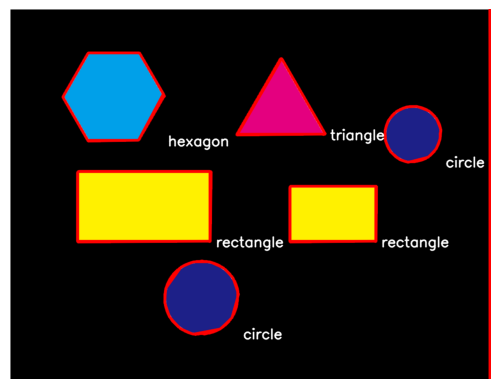

In [15]:
plt.imshow(result)
plt.axis("off")
plt.show()

## 実写真からの図形の検出

続いては、以下の駅の写真から看板を抜き出してみよう。

```{image}  ../../data/inawashiro.jpg
:align: center
:width: 80%
```

単純図形の時と同じように輪郭線を抜き出そう。ただし、今回は自然画像であり、含まれる画像の色が様々なので少し工夫が必要になる。

### 画像の前処理

まず、エッジを抜き出す際には、細かな輝度の変化はそれほど重要ではなく、大きな輝度の変化が起こる場所だけが分かれば良い。自然画像には多くの場合、細かなノイズがのっているので、最初にぼかしフィルタをかけてノイズを減らしておく。

次に、看板が白いことに注目して、グレースケール画像を先に二値化してしまう。この際、自動で閾値を決める方法に「大津の二値化」と呼ばれる方法がある。大津の二値化は画像を輝度のヒストグラムとして表わしたときに、2つに分けられたヒストグラムのそれぞれが持つ色の分散をできる限り小さくするように閾値を決める。

In [16]:
image = cv2.imread("../../data/inawashiro.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# ぼかし処理
gray = cv2.GaussianBlur(gray, None, 3.0)

# 大津の二値化
thr, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

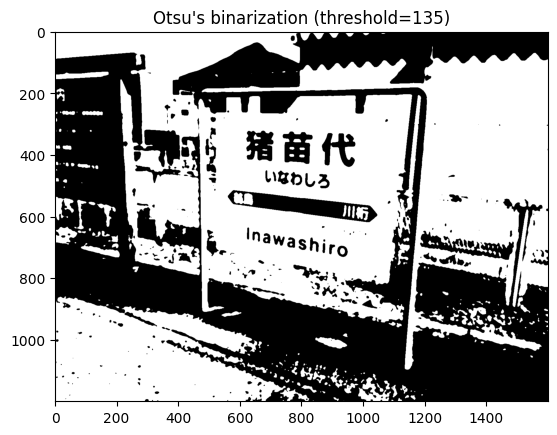

In [17]:
plt.imshow(binary, cmap="gray")
plt.title("Otsu's binarization (threshold={:d})".format(int(thr)))
plt.show()

大津の二値化では、上記のように「自然画像を自然なまま二値化」した画像が得られるため、より白い領域だけを残すように閾値を調整する。`threshold`の第1戻り値は実際に二値化に用いた閾値であるため、これを少し大きくなるようにスケーリングして、再度二値化処理をかける。

In [18]:
new_thr = min(int(thr * 1.5), 255)
_, binary = cv2.threshold(gray, new_thr, 255, cv2.THRESH_BINARY)

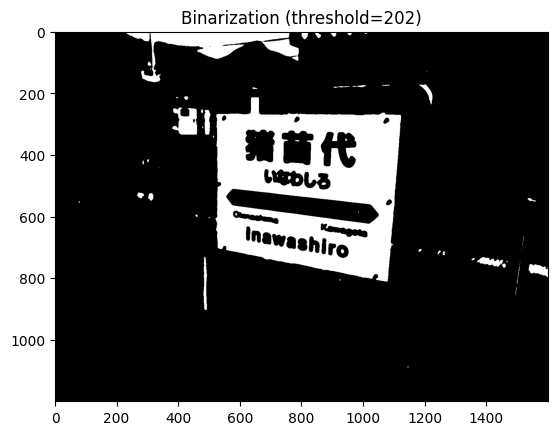

In [19]:
plt.imshow(binary, cmap="gray")
plt.title("Binarization (threshold={:d})".format(int(new_thr)))
plt.show()

すると、上記のように看板の部分だけが強調されたような画像を得ることができる。

### エッジの検出

二値化により前処理した画像から「基本図形」の時と同様にエッジを検出する。今回はCanny法によりエッジを検出し、モルフォロジー演算で余計な輪郭線を除去する。この際、dilationとerosionでdilation側の構造要素を少し大きめに取っておくと、エッジがはっきりと残る。

In [20]:
edge = cv2.Canny(binary, 150, 200)
edge = cv2.dilate(edge, np.ones((11, 11), dtype=edge.dtype))
edge = cv2.erode(edge, np.ones((9, 9), dtype=edge.dtype)) 

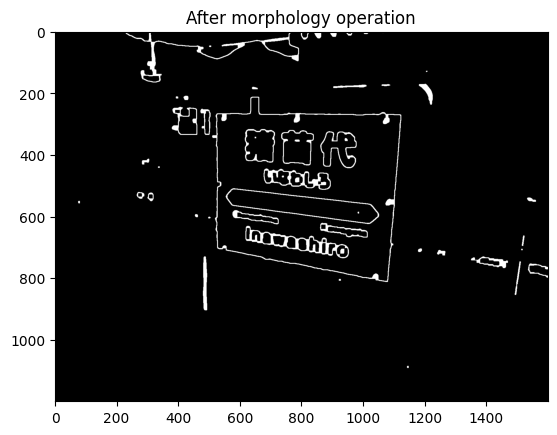

In [21]:
plt.imshow(edge, cmap="gray")
plt.title("After morphology operation".format(int(new_thr)))
plt.show()

### 図形の検出

看板を取り出すための方針として、写真に写っている物のうち、**輪郭線が最も長いもの**が写真に写っている主要物体であると仮定する。この仮定に基づき、各輪郭線の長さを計算し、最も長い輪郭線だけを残す。

まずは`findContours`を使って、どのような輪郭線が抽出されるのかを確認する。仮定に基づいて処理を行う際には、**考えた仮定が本当に成り立ちそうかを予め必ずチェックする**こと。

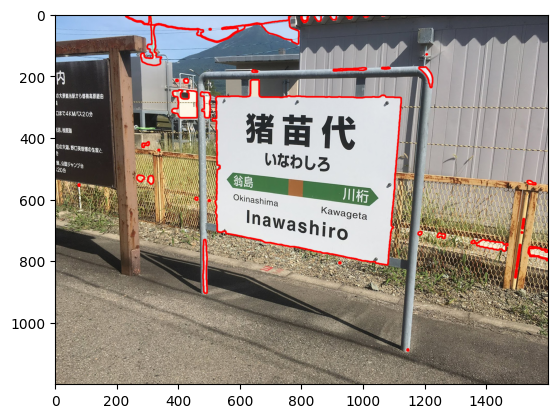

In [22]:
contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

result = image.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.show()

輪郭線の描画結果を見てみると、確かに一番長い輪郭線が看板を囲むものになっていそうに見える。実際に、輪郭線の長さを計算して、最も長い輪郭線がどれかを確認してみる。

In [23]:
longest_cnt = None
max_length = 0.0
for cnt in contours:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    if max_length < arclen:
        max_length = arclen
        longest_cnt = cnt

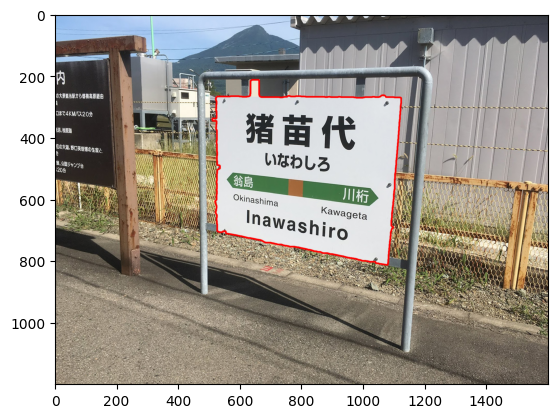

In [24]:
result = image.copy()
cv2.drawContours(result, [longest_cnt], -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.show()

確かに最も長い輪郭線が看板に対応していることが分かったので、次に看板の四つ角を取ってくる。`approxPolyDP`を使い、短い辺を潰してしまうことで四角形を得ることができる。

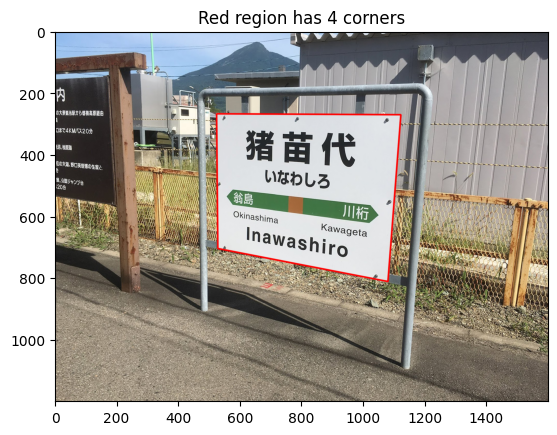

In [25]:
arclen = cv2.arcLength(longest_cnt, True)
approx = cv2.approxPolyDP(longest_cnt, arclen * 1.0e-1, True)

result = image.copy()
cv2.drawContours(result, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.title("Red region has {:d} corners".format(len(approx)))
plt.show()

図のタイトルにあるように、今、赤色で描かれている矩形の角は4つであり、これで、看板に対応する四角形を取り出すことができた。

### パースの除去

In [26]:
src_pts = approx.reshape((-1, 2)).astype("float32")

# 縦横比の計算
w = np.linalg.norm(src_pts[3] - src_pts[0])
h = np.linalg.norm(src_pts[1] - src_pts[0])
aspect = abs(w) / abs(h)

# 新しい画像サイズを設定
new_w = int(1000 * aspect)
new_h = 1000
dst_pts = np.array([(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)], dtype="float32")

# 射影変換を計算して、パースをキャンセルする
warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
result = cv2.warpPerspective(image, warp, (new_w, new_h))

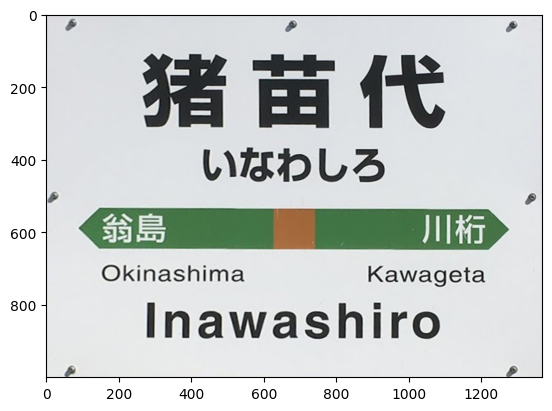

In [27]:
plt.imshow(result)
plt.show()

## 練習問題

* 上記の方法でも、正しく看板を抜き出すことができたが、**一番長い輪郭線に囲まれた領域が欲しい領域**という仮定が成り立たない場合もある。この場合には、同じく看板が白いことに着目して、**二値化した時点で一番大きな白の領域を取り出す**という方法もある。最大の白色領域を取り出した後で、その最も外側にある輪郭を、看板の輪郭線とすれば、より背景の影響を受けづらくすることができる。この方法を実際にコード化し、正しく看板が取り出せることを確かめよ。